# Happy Customers - An Apziva Project

By Samuel Alter

This project centers on a customer survey dataset from a delivery company. The dataset consists of the following:
* `Y`: The target attribute, indicating whether the customer noted their happiness or unhappiness
* `X1`: Order was delivered on time
* `X2`: Contents of the order was as expected (think: after the order has been delivered)
* `X3`: I ordered everything that I wanted to order (think: while placing the order)
* `X4`: I paid a good price for my order
* `X5`: I am satisfied with my courier
* `X6`: The app makes ordering easy for me

Attributes `X1` through `X6` are on a 1 to 5 scale, with 5 indicating most agreement with the statement.

The goals of this project are to train a model that predicts whether a customer is happy or not, based on their answers to the survey. Specifically, I am to reach 73% accuracy or higher with my modeling, or explain why my solution is superior.

A stretch goal would be to determine which features are more important when predicting a customer's happiness. What is the minimal set of attributes or features that would preserve the most information about the problem, while at the same time increasing predictability? The aim here is to see if any question can be eliminated in the next survey round.

The statistical analysis of the features can be found in the [Statistical Modeling](#statistical_modeling) section at the end of this document.

## Table of Contents

1. [EDA](#eda)
> [EDA Summary](#eda_sum)
1. [Initial `lazypredict` model exploration](#lazy_predict)
> * [Random seed initialization](#rand). This output is saved to a file so that it can be accessed later on in the notebook when using a different environment.
> * [Read in and setup dataset](#read)
> * [Run `LazyClassifier`](#lazy)
1. `XGBoost`
> * [Initial XGBoost model run](#xgboost_initial)
> * [Grid search exploration with the `XGboost` algorithm](#xgboost)
1. [`LGBMClassifier`](#lgbm)
> * [`get_dummies`](#lgbm_dummies)
1. [`SGDClassifier`](#sgdc)
> Grid search exploration with the `SGDClassifier` algorithm
> * [`get_dummies`](#sgdc_dummies)
> * [`train_test_split` on OHE'd dataset](#tts_ohe)
> * [Pipeline with `SGDClassifier` and OHE'd data](#pipe_ohe)
> * [Most important features of the OHE'd data](#rfe_ohe)
> * [New pipeline with `SGDClassifier` and categorical (not OHE'd) data](#pipe_notohe)
> * [Most important features of the non-OHE'd data](#rfe_notohe)
> * [Last attempt at pipeline and grid search with thresholded (non-OHE'd) data](#thresholded_grid)
> * [Most important features on the thresholded data](#rfe_threshold)
1. [`hyperopt`](#hyper)
> Our accuracies are still volatile and not ideal, so we will use the `hyperopt` package to help us arrive at better hyperparameters.

## EDA <a name='eda'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('../data/1_data.csv')
df.head(3)

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5


Let's rename the columns to make them more intuitive.

In [3]:
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

# using alphabet prefixes to ensure correct order of columns

In [4]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset")

There are 126 rows and 7 columns in the dataset


In [5]:
df.describe()

,y,a_time,b_contents,c_complete,d_price,e_courier,f_app
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


It seems like most of the participants in the survey were happy about the time it took to receive the order and app experience, but all of this will require more exploration.

In [6]:
df['y'].value_counts()

y
1    69
0    57
Name: count, dtype: int64

### Figure 1: Distribution of target (Y)

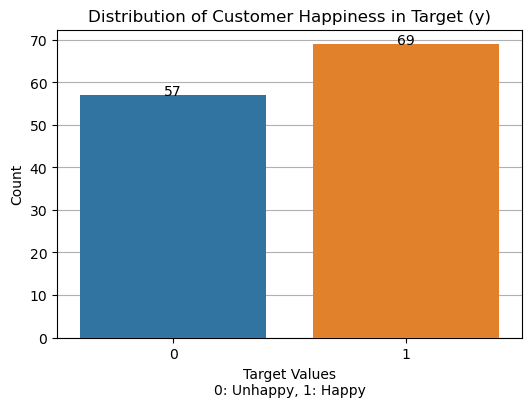

In [7]:
# data labels
x=[0,1]
y=[df['y'].value_counts()[0],df['y'].value_counts()[1]]

plt.figure(figsize=(6, 4))
ax=sns.countplot(data=df, x='y',zorder=3,)
plt.title('Distribution of Customer Happiness in Target (y)')
plt.xlabel('Target Values\n0: Unhappy, 1: Happy')
plt.ylabel('Count')
ax.yaxis.grid(True,zorder=0)
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha = 'center')
plt.savefig('../figs/1_ydistribution.pdf')
plt.savefig('../figs/1_ydistribution.png')
plt.show()

In [8]:
print(f"In the dataset, {round(df['y'].value_counts()[1]/df['y'].shape[0]*100,2)}% of respondents were happy,\nwhile {round(df['y'].value_counts()[0]/df['y'].shape[0]*100,0)}% of respondents were unhappy.")

In the dataset, 54.76% of respondents were happy,
while 45.0% of respondents were unhappy.


In [9]:
# prepare X data for plotting
col_list=[]

for i in df.columns:
    col_list.append(i)
    
col_list.remove('y')

df_melted=df.melt(value_vars=col_list,var_name='Variable',value_name='Value')

# calculate mean value per variable
mean_values=df_melted.groupby('Variable')['Value'].mean().to_dict()

In [10]:
mean_values

{'a_time': 4.333333333333333,
 'b_contents': 2.5317460317460316,
 'c_complete': 3.3095238095238093,
 'd_price': 3.746031746031746,
 'e_courier': 3.6507936507936507,
 'f_app': 4.253968253968254}

In [11]:
# create custom labels for following figure
labels=[f"{variable}: {mean_values[variable]:.2f}" for variable in mean_values.keys()]
labels

['a_time: 4.33',
 'b_contents: 2.53',
 'c_complete: 3.31',
 'd_price: 3.75',
 'e_courier: 3.65',
 'f_app: 4.25']

In [12]:
df_melted['Variable'].value_counts()

Variable
a_time        126
b_contents    126
c_complete    126
d_price       126
e_courier     126
f_app         126
Name: count, dtype: int64

In [13]:
xlabs=['Delivery Time',
       'Contents of Order',
       'Order Completeness',
       'Price for Order',
       'Satisfaction with Courier',
       'Satisfaction with App Experience']

### Figure 2: Distribution of survey results

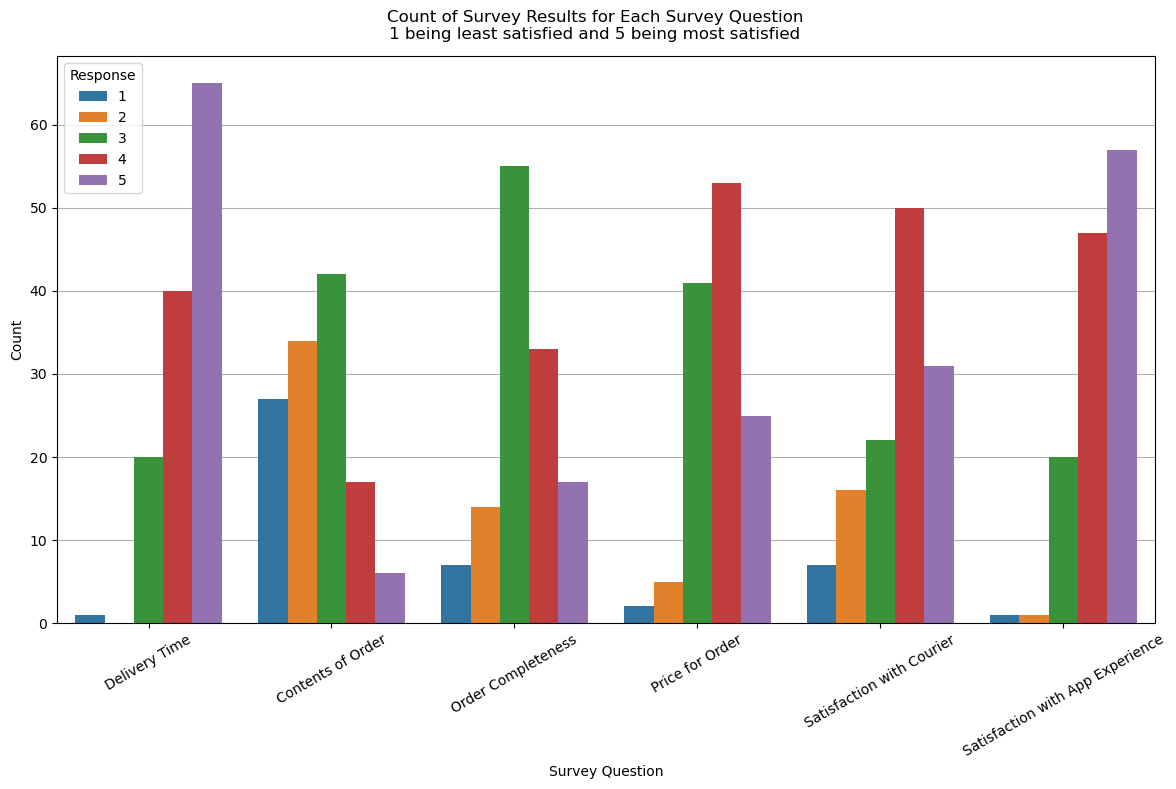

In [14]:
# plot distribution of survey results

plt.figure(figsize=(12,8))
ax=sns.countplot(data=df_melted,x='Variable',hue='Value')
plt.suptitle('Count of Survey Results for Each Survey Question\n1 being least satisfied and 5 being most satisfied')
plt.xlabel('Survey Question')
plt.ylabel('Count')
ax.set_axisbelow(True)
ax.yaxis.grid(True,which='major')
ax.set_xticklabels(xlabs)
plt.xticks(rotation=30)
plt.legend(title='Response',loc='upper left')
plt.tight_layout()
plt.savefig('../figs/1_xdistribution.pdf')
plt.savefig('../figs/1_xdistribution.png')
plt.show()

This plot illustrates well the distribution of responses received in the survey. Although it is harder to draw conclusions from this figure, I think it is still valid to understand the overall trends in the data. Figure 3 has more explanatory value.

In [15]:
# setup labels for mean values
mean_values=df_melted.groupby('Variable')['Value'].mean()
mean_values=mean_values.round(decimals=2)
mean_values

Variable
a_time        4.33
b_contents    2.53
c_complete    3.31
d_price       3.75
e_courier     3.65
f_app         4.25
Name: Value, dtype: float64

In [16]:
# data labels
x=list(np.arange(6))
y=mean_values.iloc[:6].tolist()

print("x:")
print(x)
print("y:")
print(y)

x:
[0, 1, 2, 3, 4, 5]
y:
[4.33, 2.53, 3.31, 3.75, 3.65, 4.25]


### Figure 3: Mean response to survey question

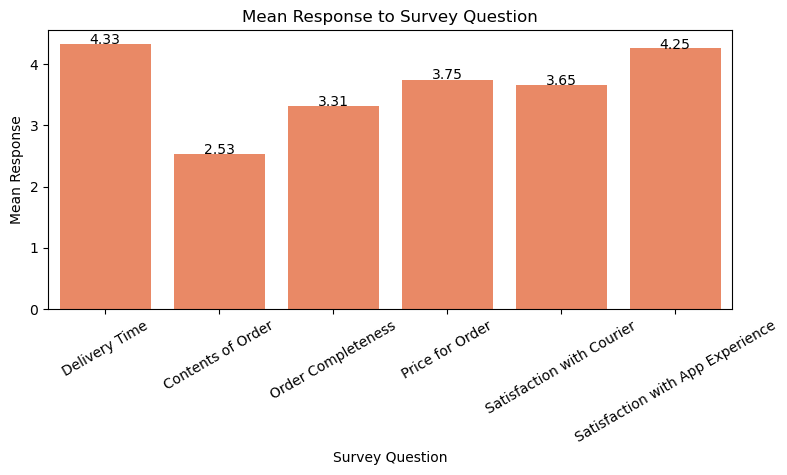

In [17]:
plt.figure(figsize=(10,6))
ax=sns.barplot(data=df_melted,x='Variable',y='Value',errorbar=None,color='coral')
plt.tight_layout(pad=10)
# plot labels
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha='center')
ax.set_xticklabels(xlabs,rotation=30)
ax.set_title('Mean Response to Survey Question')
ax.set_ylabel('Mean Response')
ax.set_xlabel('Survey Question')
plt.savefig('../figs/1_xmeandistribution.pdf')
plt.savefig('../figs/1_xmeandistribution.png')
plt.show()

The delivery time and app experience had the highest mean satisfaction in the survey, with the contents having the lowest overall.

### Figure 4: Correlation matrix

/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


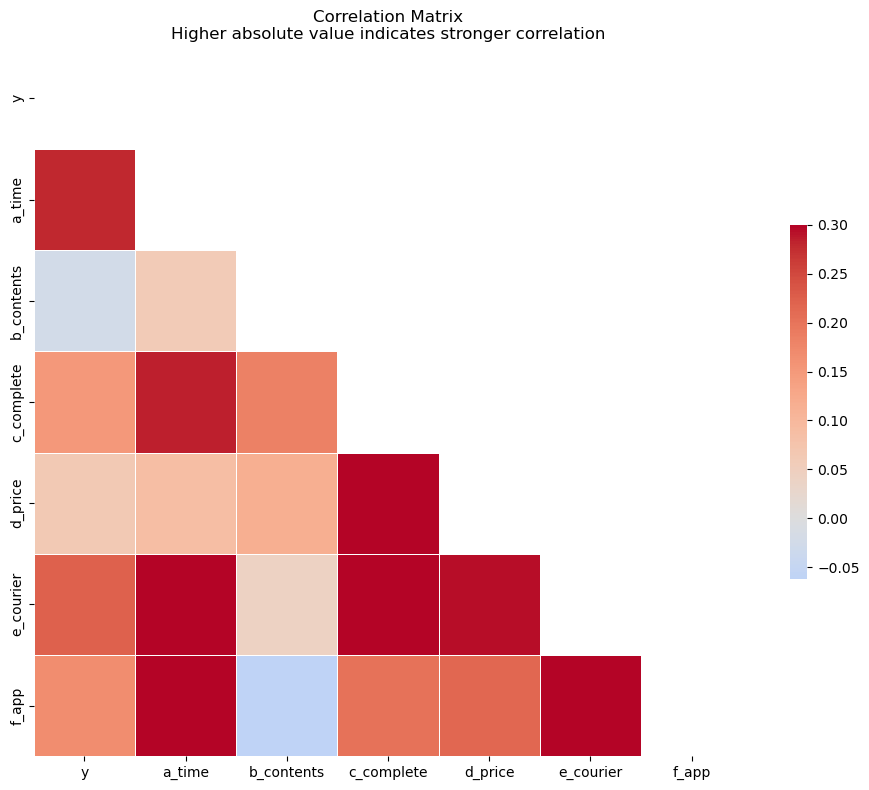

In [39]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f,ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True,
            cbar_kws={"shrink": .5})
plt.title('Correlation Matrix\nHigher absolute value indicates stronger correlation')
plt.tight_layout()

# save fig
plt.savefig('../figs/1_corrmatrix.pdf')
plt.savefig('../figs/1_corrmatrix.png')

The results of the correlation matrix show that if one aspect of the experience is positive, the customer will rate others positive as well. One interesting correlation to highlight is the courier and time are connected, which makes sense: the courier is the person that gives you your order, and if the courier is on time you probably will rate the courier highly too.

### EDA Summary <a name='eda_sum'></a>

In the dataset that we were given, roughly half of the respondents were unhappy. From a business standpoint, this is an opportunity to increase the amount of satisfied customers. Hence the survey, ostensibly to understand how the company can improve the satisfaction of their customers.

The results from the survey show that the delivery time and the app experience are places where the company is doing well. Areas for improvement are ensuring that the order is prepared correctly and customers being able to find what they need when they place an order.

We need to do more modeling to understand which survey questions are most important and which can be removed. We will do this in the subsequent sections below.

## `lazypredict` <a name='lazy_predict'></a>

[`lazypredict`](#https://lazypredict.readthedocs.io/en/latest/) is a very helpful package that can run through generic builds of a multitude of models in order to get a high-level understanding of the performance of these models on your particular dataset. It is a great place to start and saves a lot of time that would be spent manually exploring the accuracy of different models.

In [44]:
import numpy as np
import pandas as pd

In [46]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

### Specify random seed <a name='rand'></a>

In [47]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    rng=np.random.default_rng()
    random_state=rng.integers(low=low,high=high)
    return random_state

In [48]:
# define random seed
seed=rand_gen()
seed

7795

In [49]:
# save random seed to file to access it later in the notebook
with open('random_seed.txt','w') as file:
    file.write(str(seed))

In [50]:
# verify that the number got saved
with open('random_seed.txt','r') as file:
    saved_seed=int(file.read())
    print(saved_seed)
    seed=saved_seed

7795


In [51]:
# source:
# https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

# set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
# set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
# set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x10BFAAF80

### Specify test_size

We want to have the most performant model as possible. We will try a `test_size` of 10%, rather than my usual 20%, to get the model to train on more data and hopefully have a better performance.

In [61]:
test_size=0.10

# save random seed to file to access it later in the notebook
with open('test_size.txt','w') as file:
    file.write(str(test_size))
    
# verify that the number got saved
with open('test_size.txt','r') as file:
    opened_test_size=float(file.read())
    print(opened_test_size)
    test_size=opened_test_size

0.1


### Read in and setup dataset <a name='read'></a>

In [52]:
# read in and setup dataset

df=pd.read_csv('../data/1_data.csv')

# renaming columns to preserve order
# and make them more intelligible
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

# df.dtypes

X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y'].copy().astype('int8') # because it's a binary

We'll perform the `LazyClassifier` on both OHE'd and non-OHE'd data.

#### `get_dummies`<a name='lgbm_dummies'></a>

In [86]:
X.dtypes

a_time        int64
b_contents    int64
c_complete    int64
d_price       int64
e_courier     int64
f_app         int64
dtype: object

`pd.get_dummies` requires the data be categorical:

In [87]:
X_cat=X.copy()

for col in X_cat.columns:
    X_cat[col] = X_cat[col].astype('category')
    
X_cat.dtypes

a_time        category
b_contents    category
c_complete    category
d_price       category
e_courier     category
f_app         category
dtype: object

In [88]:
X_ohe=pd.get_dummies(data=X_cat,
                     prefix=list(X_cat.columns),
                     drop_first=False) # I want to 
                                       # see all survey responses
                                       # that are in dataset

In [112]:
# train/test split
X_train_ohe, \
X_test_ohe, \
y_train_ohe, \
y_test_ohe = train_test_split(X_ohe, 
                          y, 
                          test_size=test_size, 
                          stratify=y,
                          random_state=seed)

In [113]:
print(f'''
Shapes of splits:
X_train: {X_train_ohe.shape}
X_test:  {X_test_ohe.shape}
y_train: {y_train_ohe.shape}
y_test:  {y_test_ohe.shape}
''')


Shapes of splits:
X_train: (113, 29)
X_test:  (13, 29)
y_train: (113,)
y_test:  (13,)



#### Non OHE'd train/test splits

In [114]:
X_train, \
X_test, \
y_train, \
y_test = train_test_split(X, 
                          y, 
                          test_size=test_size, 
                          stratify=y,
                          random_state=seed)

In [115]:
print(f'''
Shapes of splits:
X_train: {X_train.shape}
X_test:  {X_test.shape}
y_train: {y_train.shape}
y_test:  {y_test.shape}
''')


Shapes of splits:
X_train: (113, 6)
X_test:  (13, 6)
y_train: (113,)
y_test:  (13,)



### Run LazyClassifier <a name='lazy'></a>

In [128]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     random_state=seed)

In [129]:
models_ohe, predictions_ohe = clf.fit(X_train=X_train_ohe,
                              X_test=X_test_ohe,
                              y_train=y_train_ohe,
                              y_test=y_test_ohe)

100%|███████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1320.33it/s]


Results from the `LazyClassifier`:  <a name='lazy_predict_results'></a>

Save `models_ohe` object:

In [131]:
import csv
from datetime import datetime

# get current date and time
current_datetime=datetime.now()

# print current date and time to check
print(current_datetime)

# format the datetime for a filename
datetime_suffix=current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# create filename with the datetime suffix
file_name=f'../joblib/1_lazypredict_modelsohe_{datetime_suffix}.csv'
print(file_name)

# save model
models_ohe.to_csv(file_name, index=True)

2024-06-12 19:48:23.576470
../joblib/1_lazypredict_modelsohe_2024-06-12_19-48-23.csv


In [132]:
models_ohe_file_name='../joblib/1_lazypredict_modelsohe_2024-06-12_19-48-23.csv'

In [133]:
# extract models
models_ohe=pd.read_csv(models_ohe_file_name)
models_ohe

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
0,DummyClassifier,0.54,0.50,0.50,0.38,0.00


Interesting that the OHE data does not yield many results when run in `LazyClassifier`.

In [135]:
models, predictions = clf.fit(X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test)

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|█████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 45.70it/s]

[LightGBM] [Info] Number of positive: 62, number of negative: 51
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 113, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.548673 -> initscore=0.195309
[LightGBM] [Info] Start training from score 0.195309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Save `models` object:

In [137]:
import csv
from datetime import datetime

# get current date and time
current_datetime=datetime.now()

# print current date and time to check
print(current_datetime)

# format the datetime for a filename
datetime_suffix=current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# create filename with the datetime suffix
file_name=f'../joblib/1_lazypredict_models_{datetime_suffix}.csv'
print(file_name)

# save model
models.to_csv(file_name, index=True)

2024-06-12 19:49:33.025826
../joblib/1_lazypredict_models_2024-06-12_19-49-33.csv


In [139]:
models_file_name='../joblib/1_lazypredict_models_2024-06-12_19-49-33.csv'

In [140]:
# extract models
models=pd.read_csv(models_file_name)
models

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
0,QuadraticDiscriminantAnalysis,0.69,0.69,0.69,0.69,0.01
1,DecisionTreeClassifier,0.62,0.62,0.62,0.62,0.01
2,NuSVC,0.62,0.62,0.62,0.62,0.01
3,LGBMClassifier,0.62,0.61,0.61,0.61,0.07
4,SVC,0.62,0.61,0.61,0.61,0.01
5,ExtraTreesClassifier,0.62,0.61,0.61,0.61,0.06
6,GaussianNB,0.62,0.60,0.60,0.59,0.01
7,CalibratedClassifierCV,0.62,0.58,0.58,0.53,0.02
8,BaggingClassifier,0.54,0.54,0.54,0.54,0.02
9,XGBClassifier,0.54,0.54,0.54,0.54,0.09


After exploring alternatives, including `LGBMClassifier`, I will now use `XGBoost` instead. In a previous iteration, a previous `random_seed`, it had given me the second-highest accuracy. You'll note that XGBoost is now at a different rank in the model options. This is a lesson that I must always specify a `random_state` to ensure reproducibility.

## Correlation Matrix on `get_dummies` data

We should `get_dummies` on our dataset and run a correlation matrix because I'm curious. With the dataset transformed to be OneHotEncoded, rather than staying categorical, would different correlations jump out at us? Let's see.

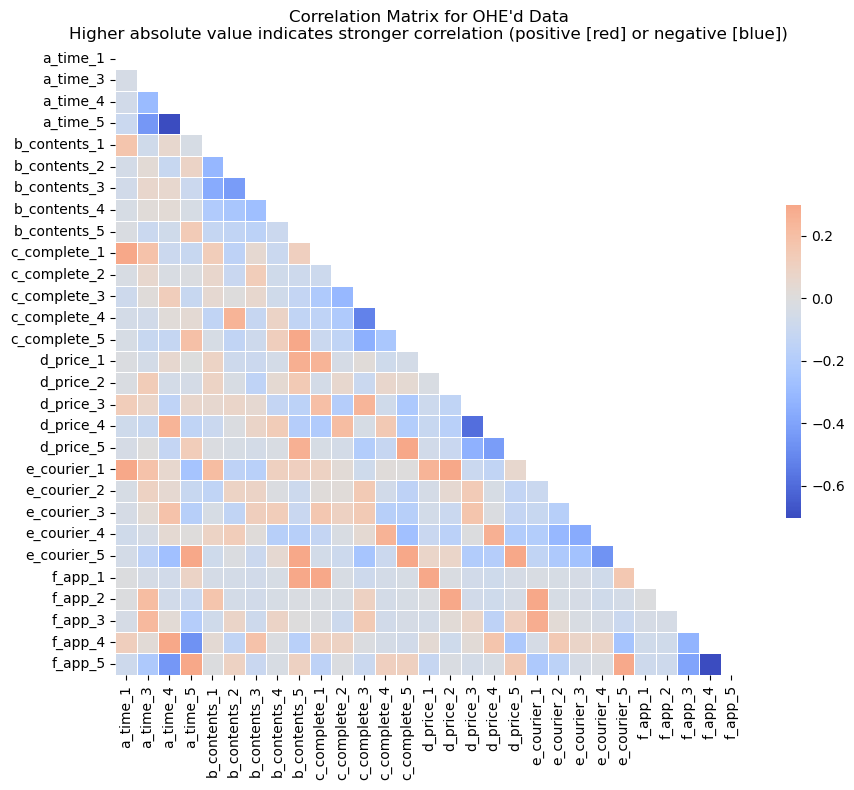

In [89]:
from matplotlib import pyplot as plt
import seaborn as sns

# Compute the correlation matrix
corr = X_ohe.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f,ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True,
            cbar_kws={"shrink": .5},
            annot_kws={"size":5})
plt.title("Correlation Matrix for OHE'd Data\nHigher absolute value indicates stronger correlation (positive [red] or negative [blue])")
plt.tight_layout()

# save fig
plt.savefig('../figs/1_corrmatrix_ohe.pdf')
plt.savefig('../figs/1_corrmatrix_ohe.png')

Nothing much to learn here except that if a specific category scored high, other categories likely scored high. This is also true if categories scored low. Some categories are missing as there is no data recorded for them. For example, no respondent scored `time` as a `2`.

I'm curious why, for example, people that scored the `app` as `4` were not likely to score the `time` as `5`. This may be explained later in our modeling and statistical analysis.

## `XGBClassifier`

### Imports

In [84]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Initial model run <a name='xgboost_initial'></a>

In [85]:
xgbc = XGBClassifier(random_state=seed)
xgbc.fit(X_train, y_train)

y_pred = xgbc.predict(X_test)
print(f'Score on test: {xgbc.score(X_test,y_test)}')
print(classification_report(y_test, y_pred))

Score on test: 0.5384615384615384
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.57      0.57      0.57         7

    accuracy                           0.54        13
   macro avg       0.54      0.54      0.54        13
weighted avg       0.54      0.54      0.54        13



The base model is not great yet. Let's keep going forward.

## `LGBMClassifier` <a name='lgbm'></a>

Per the past results from the `lazypredict` [here](#lazy_predict_results), I will switch to the `LGBMClassifier`. I will `RFE` for feature elimination. This gets at the stretch goal of the company who gave us the dataset.

### `train_test_split` on the OHE'd dataset <a name='tts_ohe'></a>

In [90]:
# train/test split
X_train_ohe, \
X_test_ohe, \
y_train_ohe, \
y_test_ohe = train_test_split(X_ohe, 
                          y, 
                          test_size=test_size, 
                          stratify=y,
                          random_state=seed)

In [91]:
# confirm that the split occurred
print(f'''
Shapes of splits:
X_train: {X_train_ohe.shape}
X_test:  {X_test_ohe.shape}
y_train: {y_train_ohe.shape}
y_test:  {y_test_ohe.shape}
''')


Shapes of splits:
X_train: (113, 29)
X_test:  (13, 29)
y_train: (113,)
y_test:  (13,)



In [92]:
X_train_ohe.head(3)

,a_time_1,a_time_3,a_time_4,a_time_5,b_contents_1,b_contents_2,b_contents_3,b_contents_4,b_contents_5,c_complete_1,...,e_courier_1,e_courier_2,e_courier_3,e_courier_4,e_courier_5,f_app_1,f_app_2,f_app_3,f_app_4,f_app_5
112,False,False,True,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
51,False,False,False,True,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
27,False,True,False,False,False,False,True,False,False,True,...,False,False,True,False,False,False,False,False,True,False


Great, now we're ready to run the `LGBMClassifier`.

In [93]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

### `LGBMClassifier` with

### `LGBMClassifier` with OHE'd data

In [95]:
model=lgb.LGBMClassifier(random_state=seed,verbose=-1)
print(model)
model.fit(X_train_ohe,y_train_ohe)
print("fitting model")
y_pred=model.predict(X_test_ohe)
print(y_pred)
accuracy=accuracy_score(y_test_ohe,y_pred)
print(f'Accuracy: {accuracy:.2f}')

LGBMClassifier(random_state=7795, verbose=-1)
fitting model
[1 0 1 1 0 0 1 0 0 1 1 1 0]
Accuracy: 0.69


#### Would `drop_first=True` help at all?

In [102]:
X_ohe_drop1=pd.get_dummies(data=X_cat,
                     prefix=list(X_cat.columns),
                     drop_first=True) # What if we drop_first?

In [105]:
# train/test split on drop first data
X_train_ohe_drop1, \
X_test_ohe_drop1, \
y_train_ohe_drop1, \
y_test_ohe_drop1 = train_test_split(X_ohe_drop1, 
                          y, 
                          test_size=test_size, 
                          stratify=y,
                          random_state=seed)

In [107]:
# confirm that the split occurred
print(f'''
Shapes of splits:
X_train: {X_train_ohe_drop1.shape}
X_test:  {X_test_ohe_drop1.shape}
y_train: {y_train_ohe_drop1.shape}
y_test:  {y_test_ohe_drop1.shape}
''')


Shapes of splits:
X_train: (113, 23)
X_test:  (13, 23)
y_train: (113,)
y_test:  (13,)



In [108]:
X_train_ohe_drop1.head(3)

,a_time_3,a_time_4,a_time_5,b_contents_2,b_contents_3,b_contents_4,b_contents_5,c_complete_2,c_complete_3,c_complete_4,...,d_price_4,d_price_5,e_courier_2,e_courier_3,e_courier_4,e_courier_5,f_app_2,f_app_3,f_app_4,f_app_5
112,False,True,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
51,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,True,False
27,True,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


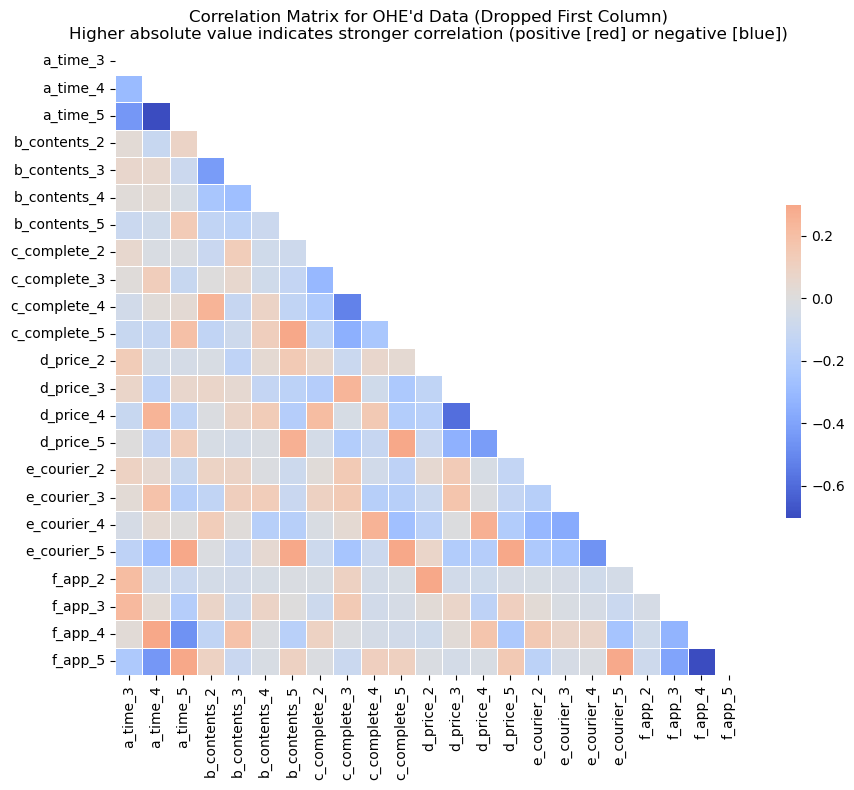

In [111]:
# Compute the correlation matrix
corr = X_ohe.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f,ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True,
            cbar_kws={"shrink": .5},
            annot_kws={"size":5})
plt.title("Correlation Matrix for OHE'd Data (Dropped First Column)\nHigher absolute value indicates stronger correlation (positive [red] or negative [blue])")
plt.tight_layout()

# save fig
plt.savefig('../figs/1_corrmatrix_ohe_dropfirst.pdf')
plt.savefig('../figs/1_corrmatrix_ohe_dropfirst.png')

In [110]:
model=lgb.LGBMClassifier(random_state=seed,verbose=-1)
print(model)
model.fit(X_train_ohe_drop1,y_train_ohe_drop1)
print("fitting model")
y_pred=model.predict(X_test_ohe_drop1)
print(y_pred)
accuracy=accuracy_score(y_test_ohe_drop1,y_pred)
print(f'Accuracy: {accuracy:.2f}')

LGBMClassifier(random_state=7795, verbose=-1)
fitting model
[1 0 1 1 0 0 1 0 0 1 1 1 0]
Accuracy: 0.69


#### No difference.

### `LGBMClassifier` with Thresholded data

What if we ran the same base model with the thresholded data?

In [97]:
# define thresholding function
# if the person scored a category as a 4 or 5,
# we give a value of 1. Otherwise, we give it a 0
threshold_func = lambda x: 1 if x >= 4 else 0

# apply the function to the dataframe
X_threshold = X.applymap(threshold_func)
X_threshold

# train/test split
X_train_threshold, \
X_test_threshold, \
y_train_threshold, \
y_test_threshold = train_test_split(X_threshold, 
                          y, 
                          test_size=test_size, 
                          stratify=y,
                          random_state=seed)

In [98]:
model=lgb.LGBMClassifier(random_state=seed,verbose=-1)
print(model)
model.fit(X_train_threshold,y_train_threshold)
print("fitting model")
y_pred=model.predict(X_test_threshold)
print(y_pred)
accuracy=accuracy_score(y_test_threshold,y_pred)
print(f'Accuracy: {accuracy:.2f}')

LGBMClassifier(random_state=7795, verbose=-1)
fitting model
[1 0 1 1 0 1 1 0 1 1 1 0 1]
Accuracy: 0.54


#### This was worse.

This is an interesting result. The thresholding did not perform as well as the OHE'd dataset.

## `DecisionTreeClassifier`

### `DecisionTreeClassifier` on OHE'd data

This should yield a good result, as `LazyClassifier` scored it highly. However, when we run the generic model...

In [141]:
from sklearn.tree import DecisionTreeClassifier

In [142]:
model=DecisionTreeClassifier(random_state=seed)
print(model)
model.fit(X_train_ohe,y_train_ohe)
print("fitting model")
y_pred=model.predict(X_test_ohe)
print(y_pred)
accuracy=accuracy_score(y_test_ohe,y_pred)
print(f'Accuracy: {accuracy:.2f}')

DecisionTreeClassifier(random_state=7795)
fitting model
[0 1 0 1 0 0 1 0 1 1 1 1 0]
Accuracy: 0.54


### `DecisionTreeClassifier` on thresholded data

In [150]:
model=DecisionTreeClassifier(random_state=seed)
print(model)
model.fit(X_train_threshold,y_train_threshold)
print("fitting model")
y_pred=model.predict(X_test_threshold)
print(y_pred)
accuracy=accuracy_score(y_test_threshold,y_pred)
print(f'Accuracy: {accuracy:.2f}')

DecisionTreeClassifier(random_state=7795)
fitting model
[1 0 0 1 0 0 1 0 0 1 1 0 0]
Accuracy: 0.54


### `DecisionTreeClassifier` on regular data

In [151]:
model=DecisionTreeClassifier(random_state=seed)
print(model)
model.fit(X_train,y_train)
print("fitting model")
y_pred=model.predict(X_test)
print(y_pred)
accuracy=accuracy_score(y_test,y_pred)
print(f'Accuracy: {accuracy:.2f}')

DecisionTreeClassifier(random_state=7795)
fitting model
[0 0 1 1 0 0 1 0 0 0 1 1 1]
Accuracy: 0.62


...We see that it does not perform well out of the box. We'll use `hyperopt` next.

## `QuadraticDiscriminatnAnalysis`

In [143]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

### OHE'd data

In [145]:
model=QuadraticDiscriminantAnalysis()
print(model)
model.fit(X_train_ohe,y_train_ohe)
print("fitting model")
y_pred=model.predict(X_test_ohe)
print(y_pred)
accuracy=accuracy_score(y_test_ohe,y_pred)
print(f'Accuracy: {accuracy:.2f}')

QuadraticDiscriminantAnalysis()
fitting model
[0 0 1 1 0 0 0 0 1 0 1 1 0]
Accuracy: 0.54


### Thresholded data

In [146]:
model=QuadraticDiscriminantAnalysis()
print(model)
model.fit(X_train_threshold,y_train_threshold)
print("fitting model")
y_pred=model.predict(X_test_threshold)
print(y_pred)
accuracy=accuracy_score(y_test_threshold,y_pred)
print(f'Accuracy: {accuracy:.2f}')

QuadraticDiscriminantAnalysis()
fitting model
[1 1 1 1 0 0 1 1 0 1 1 1 1]
Accuracy: 0.62


### Regular data

In [152]:
model=QuadraticDiscriminantAnalysis()
print(model)
model.fit(X_train,y_train)
print("fitting model")
y_pred=model.predict(X_test)
print(y_pred)
accuracy=accuracy_score(y_test,y_pred)
print(f'Accuracy: {accuracy:.2f}')

QuadraticDiscriminantAnalysis()
fitting model
[0 0 1 1 1 0 0 1 0 1 1 1 0]
Accuracy: 0.69


### `hyperopt` <a name='hyper'></a>

Tutorials are [here](#http://hyperopt.github.io/hyperopt/tutorials/01.BasicTutorial/) and [here](#https://towardsdev.com/optimizing-hyperparameters-with-hyperopt-a-hands-on-tutorial-2839efcbc177?gi=de88b6cfe1cd).  
And I'm following examples from [here](#https://github.com/hyperopt/hyperopt-sklearn) and [here](#https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce).

In [ ]:
import numpy as np
import pandas as pd

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split

#### Run `hyperopt` with `RFE` and `ExtraTreeClassifier`

##### Notes on `hyperopt` parameters

* Using `RFE` to select which features are most important
* `ExtraTreeClassifier` is used as the final model as it gave good results from the `LazyPredict`

In [ ]:
class HyperoptOptimizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best = 0
        self.count = 0

    def hyperopt_train_test(self, params):
        # Extract RFE parameters
        n_features_to_select = params['n_features_to_select']
        del params['n_features_to_select']
        
        # extract classifier type
        t = params['type']
        del params['type']
        
        # define classifier based on type
        if t == 'extratrees':
            clf = ExtraTreesClassifier(**params)
        else:
            return 0
        
        # define RFE with the classifier
        rfe = RFE(estimator=clf, 
                  n_features_to_select=n_features_to_select)
        
        # perform cross-validation
        return cross_val_score(rfe, self.X, self.y).mean()

    def objective(self, params):
        self.count += 1
        acc = self.hyperopt_train_test(params.copy())
        if acc > self.best:
            print('new best:', acc, 'using', params['type'])
            self.best = acc
        if self.count % 25 == 0:
            print('iters:', self.count, ', acc:', acc, 'using', params)
        return {'loss': -acc, 'status': STATUS_OK}

# define hyperparameter space
space = hp.choice('classifier_type', [
    {
        'type': 'extratrees',
        'n_features_to_select': hp.choice('n_features_to_select', 
                                          range(1, X.shape[1]+1)),
        'n_estimators': hp.choice('n_estimators', range(10, 100)),
        'max_depth': hp.choice('max_depth', range(1, 25)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'random_state': seed
    },
])

# instantiate optimizer
optimizer = HyperoptOptimizer(X_threshold, y)

# initialize trials object
trials = Trials()

rstate = np.random.default_rng(seed)

# run optimization
best = fmin(optimizer.objective, 
            space, 
            algo=tpe.suggest, 
            max_evals=10, 
            trials=trials,
            rstate=rstate,
            return_argmin=False)
print('best:')
print(best)


In [ ]:
class HyperoptOptimizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best = 0
        self.count = 0

    def hyperopt_train_test(self, params):
        # Extract RFE parameters
        n_features_to_select = params['n_features_to_select']
        del params['n_features_to_select']
        
        # extract classifier type
        t = params['type']
        del params['type']
        
        # define classifier based on type
        if t == 'extratrees':
            clf = ExtraTreesClassifier(**params)
        elif t == 'randomforest':
            clf = RandomForestClassifier(**params)
        else:
            return 0
        
        # define RFE with the classifier
        rfe = RFE(estimator=clf, 
                  n_features_to_select=n_features_to_select)
        
        # perform cross-validation
        return cross_val_score(rfe, self.X, self.y).mean()

    def objective(self, params):
        self.count += 1
        acc = self.hyperopt_train_test(params.copy())
        if acc > self.best:
            print('new best:', acc, 'using', params['type'])
            self.best = acc
        if self.count % 25 == 0:
            print('iters:', self.count, ', acc:', acc, 'using', params)
        return {'loss': -acc, 'status': STATUS_OK}

# define hyperparameter space
space = hp.choice('classifier_type', [
    {
        # 'type': 'extratrees',
        'type': 'randomforest',
        'n_features_to_select': hp.choice('n_features_to_select', 
                                          range(1, X.shape[1]+1)),
        'n_estimators': hp.choice('n_estimators', range(10, 1000)),
        'max_depth': hp.choice('max_depth', range(1, 5)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'random_state': seed
    },
])

# instantiate optimizer
optimizer = HyperoptOptimizer(X_threshold, y)

# initialize trials object
trials = Trials()

rstate = np.random.default_rng(seed)

# run optimization
best = fmin(optimizer.objective, 
            space, 
            algo=tpe.suggest, 
            max_evals=100, 
            trials=trials,
            rstate=rstate,
            return_argmin=False)
print('best:')
print(best)

##### Save best parameters

In [ ]:
best

In [ ]:
import json
from datetime import datetime

# get current date and time
current_datetime=datetime.now()

# print current date and time to check
print(current_datetime)

# format the datetime for a filename
datetime_suffix=current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# create filename with the datetime suffix
file_name=f'../joblib/1_hyperopt_bestparams_{datetime_suffix}.json'
print(file_name)

# save model
with open(file_name,'w') as file:
    file.write(json.dumps(best,default=str))

##### Run the best parameters on the test set

In [ ]:
file_name='../joblib/1_hyperopt_lgbm_bestparams_2024-06-10_11-35-35.json'

In [ ]:
# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)
    
best_params

In [ ]:
# extract best parameters
best_n_features_to_select = best_params['n_features_to_select']
del best_params['n_features_to_select']
best_type = best_params['type']
del best_params['type']

# train final model using best parameters
if best_type == 'extratrees':
    final_clf = ExtraTreesClassifier(**best_params)
    
# define RFE with final classifier
final_rfe = RFE(estimator=final_clf, 
                n_features_to_select=best_n_features_to_select)

# fit final model on entire training set
final_rfe.fit(X_train_threshold, y_train_threshold)

# evaluate final model on test set
final_score = final_rfe.score(X_test_threshold, y_test_threshold)
print('Final test score:', final_score)

In [ ]:
y.value_counts()

In [ ]:
y.value_counts()[1]/y.shape[0]

## Run this section in the `lightgbm` environment

Import necessary packages and read in data:

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [ ]:
# open saved random seed from earlier in the notebook
with open('random_seed.txt','r') as file:
    saved_seed=int(file.read())
    print(saved_seed)
    seed=saved_seed

In [ ]:
# read in and setup dataset

df=pd.read_csv('../data/1_data.csv')

# renaming columns to preserve order
# and make them more intelligible
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y'].copy().astype('int8') # because it's a binary
                                # let's use less memory
    
X_train, \
X_test, \
y_train, \
y_test = train_test_split(X, 
                          y, 
                          test_size=0.2, 
                          stratify=y,
                          random_state=seed)

print(f'''
Shapes of splits:
X_train: {X_train.shape}
X_test:  {X_test.shape}
y_train: {y_train.shape}
y_test:  {y_test.shape}
''')

In [ ]:
# define thresholding function
# if the person scored a category as a 4 or 5,
# we give a value of 1. Otherwise, we give it a 0
threshold_func = lambda x: 1 if x >= 4 else 0

# apply the function to the dataframe
X_threshold = X.map(threshold_func)
X_threshold.head(3)

In [ ]:
# train/test split
X_train_threshold, \
X_test_threshold, \
y_train_threshold, \
y_test_threshold = train_test_split(X_threshold, 
                          y, 
                          test_size=0.2, 
                          stratify=y,
                          random_state=seed)

In [ ]:
X_train_threshold.shape

In [ ]:
X_train_threshold.head(3)

#### Run `hyperopt` with `RFE` and `LGBMClassifier`

##### Notes on `hyperopt` parameters

* Using `RFE` to select which features are most important
* `LGBMClassifier` is used as the final model as it also yielded good generic results from the `LazyPredict`
* It also seems to be performant on smaller datasets, according to the work detailed [here](https://www.data-cowboys.com/blog/which-machine-learning-classifiers-are-best-for-small-datasets)

Run base model to compare with `hyperopt`:

In [ ]:
model=lgb.LGBMClassifier(random_state=seed,verbose=-1)
print(model)
model.fit(X_train_threshold,y_train_threshold)
print("fitting model")
y_pred=model.predict(X_test_threshold)
print(y_pred)
accuracy=accuracy_score(y_test_threshold,y_pred)
print(f'Accuracy: {accuracy:.2f}')

An accuracy of 58% on the base model is already an improvement. Let's now turn to `hyperopt` to see if we can improve the accuracy even more.

In [ ]:
class HyperoptOptimizer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.best = 0
        self.count = 0
        
    def hyperopt_train_test(self, params):
        # Extract RFE parameters
        n_features_to_select = params['n_features_to_select']
        del params['n_features_to_select']
        
        # extract classifier type
        t = params['type']
        del params['type']
        
        # define classifier based on type            
        if t == 'lgbm':
            clf = LGBMClassifier(**params)
        else:
            return 0
        
        # define RFE with the classifier
        rfe = RFE(estimator=clf, 
                  n_features_to_select=n_features_to_select)
        
        # create LightGBM dataset with categorical features specified
        train_data = lgb.Dataset(self.X, label=self.y, categorical_feature=[0, 1, 2, 3, 4, 5])
        
        # perform cross-validation
        return cross_val_score(rfe, self.X, self.y).mean()

    def objective(self, params):
        self.count += 1
        acc = self.hyperopt_train_test(params.copy())
        if acc > self.best:
            print(f'new best: {acc} using {params['type']} at step {self.count}')
            self.best = acc
        if self.count % 250 == 0:
            print('iters:', self.count, ', acc:', acc, 'using', params)
        return {'loss': -acc, 'status': STATUS_OK}

# define hyperparameter space
space = hp.choice('classifier_type', [
    {
        'type': 'lgbm',
        'min_data_in_bin': 1,
        'min_data_in_leaf': 1,
        'verbose': -1,
        'boosting_type': hp.choice('boosting_type',['gbdt','dart','rf']),
        'n_features_to_select': hp.choice('n_features_to_select', range(1, X_threshold.shape[1]+1)),
        'num_leaves': hp.choice('num_leaves', range(10, 500)),
        'learning_rate': hp.loguniform('learning_rate', -4, 0),
        'n_estimators': hp.choice('n_estimators', range(50, 500)),
        'max_depth': hp.choice('max_depth', range(1, 25)),
        'min_child_samples': hp.choice('min_child_samples', range(5, 250)),
        'subsample': hp.uniform('subsample', 0.01, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1),
        'random_state': seed,
        'n_jobs': -1,
        'reg_alpha': hp.uniform('reg_alpha',0.001,100),
        'reg_lambda': hp.uniform('reg_lambda',0.001,100),
        'importance_type': hp.choice('importance_type',['split','gain'])
    }
])

# instantiate optimizer
optimizer = HyperoptOptimizer(X_threshold, y)

# initialize trials object
trials = Trials()

# define random state
rstate = np.random.default_rng(seed)

# run optimization
best = fmin(optimizer.objective, 
            space, 
            algo=tpe.suggest, 
            max_evals=2000, 
            trials=trials,
            rstate=rstate,
            return_argmin=False)
print('best:')
print(best)

##### Save best parameters

In [ ]:
best

In [ ]:
import json
from datetime import datetime

# get current date and time
current_datetime=datetime.now()

# print current date and time to check
print(current_datetime)

# format the datetime for a filename
datetime_suffix=current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# create filename with the datetime suffix
file_name=f'../joblib/1_hyperopt_lgbm_bestparams_{datetime_suffix}.json'
print('filename:',file_name)

# save model
with open(file_name,'w') as file:
    file.write(json.dumps(best,default=str))

##### Run the best parameters on the test set

In [ ]:
# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)
    
best_params

In [ ]:
import json

# datetime_suffix='2024-06-10_11-35-35'
file_name='../joblib/1_hyperopt_lgbm_bestparams_2024-06-11_12-05-28.json'

# extract best params file
with open(file_name,'r') as file:
    best_params=json.load(file)
    
best_params

In [ ]:
# extract best parameters
best_n_features_to_select = best_params['n_features_to_select']
del best_params['n_features_to_select']
best_type = best_params['type']
del best_params['type']

# train final model using best parameters
# if best_type == 'extratrees':
final_clf = LGBMClassifier(**best_params)
    
# define RFE with final classifier
final_rfe = RFE(estimator=final_clf, 
                n_features_to_select=best_n_features_to_select)

# fit final model on entire training set
final_rfe.fit(X_train_threshold, y_train_threshold)

# evaluate final model on test set
final_score = final_rfe.score(X_test_threshold, y_test_threshold)
print('Final test score:', final_score)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from lightgbm import plot_importance

In [ ]:
# fit
final_clf.fit(X_test_threshold,y_test_threshold)

# Plot feature importance
plot_importance(final_clf, importance_type='gain')
plt.show()

In [ ]:
# source
# https://towardsdatascience.com/
# using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

import shap

# SHAP values for explainability
explainer = shap.Explainer(final_clf)
shap_values = explainer(X_test_threshold)
shap.summary_plot(shap_values, X_test_threshold)

In [ ]:
feature_ranking_df_threshold=pd.read_csv('../data/1_feature_ranking_df_threshold_20240531.csv').drop(columns=['Unnamed: 0'])
feature_ranking_df_threshold

Next attempt is adapted from tutorial from [MachineLearningMastery.com](#https://machinelearningmastery.com/hyperopt-for-automated-machine-learning-with-scikit-learn/):

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe

In [ ]:
# define search
model = HyperoptEstimator(regressor=any_regressor('reg'), 
                          preprocessing=any_preprocessing('pre'), 
                          loss_fn=mean_absolute_error, 
                          algo=tpe.suggest, 
                          max_evals=50, 
                          trial_timeout=30)#,
                          # seed=np.random.default_rng(seed))
# perform the search
model.fit(X_train_threshold, y_train_threshold)#,random_state=np.random.default_rng(seed))
# summarize performance
mae = model.score(X_test_threshold, y_test_threshold)
print("MAE: %.3f" % mae)
# summarize the best model
print(model.best_model())

##### More notes on the Pipeline choices:

* `RFE` is great for feature selection, as it can help you understand which features are most important. RFE requires a base estimator to assign weights to features. We can use a logistic regression model.
* We're using the `SGDClassifier` as the final step in our pipeline as it scored the top accuracy in our `lazypredict` run.
* We'll set up a grid search so that we can explore the hyperparameter space to find the best hyperparameters for our dataset.

# Apziva: UP2IqAzAWrVBrULk